In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import geopandas as gpd
import os
import scipy
from scipy.interpolate import griddata as gd
import statsmodels.formula.api as smf
import laspy
from sklearn import tree
from sklearn import ensemble
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
path = os.getenv('PUIDATA')

In [3]:
oil_data = pd.read_csv(path+'/Oil_Boilers_-_Detailed_Fuel_Consumption_and_Building_Data.csv')

In [4]:
oil_data = oil_data.drop([ 'Facility Address', 'Borough',
       'Community Board',
       'Council District','NTA',
       'Natural Gas Utility (Con Edison or National Grid', 'DEP Boiler Application #',
       'Deadline for phasing out #6 oil (i.e. data of next DEP permit renewal after July 1 2012)',
       'Boiler Model', 'Number of identical boilers','Boiler Installation Date',
       'Estimated retirement date of boiler (assuming 35 year average useful life)',
       'Is boiler dual fuel capable?',
       'Total Estimated Cosumption - Low Estimate (Gallons) ',
       'Total Estimated Cosumption - High Estimate (MMBTUs) ',
       'Total Estimated Cosumption - Low Estimate  (MMBTUs) ',
       'Deadline for complying with Audit and Retrocommissioning Law',
         'City Council District','Number of total units',
       'Total area of buildings on lot',
       'Number of buildings on property (tax lot)', 'Number of floors',
       'Year constructed', 'Condominium housing?', 'Cooperative housing?','Building Manager', 
                          'Owner', 'Owner Address'],axis=1)

In [5]:
oil_data.head()

,"BBL (Borough, Block and Lot)",Postcode,Latitude,Longitude,Census Tract,BIN,Boiler capacity (Gross BTU),Age range of boiler,Burner Model,Primary Fuel,Total Estimated Cosumption - High Estimate (Gallons),Needs to comply with Greener Greater Buildings Laws?,Building Type,Number of residential units
0,1007910062,NaN,NaN,NaN,NaN,NaN,2.80,31 to 35 years old,INDUSTRIAL COMBUSTION MEG-34S,#6,32016,NaN,Office Buildings,42
1,1012440072,NaN,NaN,NaN,NaN,NaN,14.00,26 to 30 years old,ICI DEG 175 P,#6,146000,Yes,Elevator Apartments,87
2,2025080024,NaN,NaN,NaN,NaN,NaN,2.80,Over 50 years,HEV-E-OIL AL4C,#4,30814,NaN,Elevator Apartments,30
3,2029900034,10460.0,40.835731,-73.886595,161.0,2010678.0,2.60,26 to 30 years old,HEV-E-OIL AMG 4 3/4,#4,25309,NaN,Loft Buildings,26
4,2024720028,NaN,NaN,NaN,NaN,NaN,2.59,21 to 26 years old,ICI - MMG 30,#4,25000,NaN,Elevator Apartments,36


In [6]:
bmark = pd.read_csv(path+'/nyc_benchmarking_disclosure_data_reported_in_2016.csv')

In [7]:
bmark = bmark.drop(['Unnamed: 0', 'Record Number', 'Order',
        'Co-reported BBL Status',
       'BBLs Co-reported',
        'Property Name',
       'Parent Property Id', 'Parent Property Name', 'Street Number',
       'Street Name', 'Borough',
       'DOF Benchmarking Submission Status',
       'List of All Property Use Types at Property',
       'Largest Property Use Type',
       'Largest Property Use Type - Gross Floor Area (ft²)',
       '2nd Largest Property Use Type',
       '2nd Largest Property Use - Gross Floor Area (ft²)',
       '3rd Largest Property Use Type',
       '3rd Largest Property Use Type - Gross Floor Area (ft²)', 'Year Built',
       'Number of Buildings - Self-reported', 'Occupancy',
       'Metered Areas (Energy)', 'Metered Areas  (Water)', 'ENERGY STAR Score',
        'Weather Normalized Site EUI (kBtu/ft²)',
       'Weather Normalized Site Electricity Intensity (kWh/ft²)',
       'Weather Normalized Site Natural Gas Intensity (therms/ft²)',
       'Source EUI (kBtu/ft²)', 'Weather Normalized Source EUI (kBtu/ft²)',
         'District Steam Use (kBtu)',
       'District Hot Water Use (kBtu)', 'District Chilled Water Use (kBtu)',
       'Natural Gas Use (kBtu)',
       'Weather Normalized Site Natural Gas Use (therms)',
       'Electricity Use - Grid Purchase (kBtu)',
       'Weather Normalized Site Electricity (kWh)',
       'DOF Property Floor Area (ft²)', 'Property GFA - Self-reported (ft²)',
       'Water Use (All Water Sources) (kgal)',
       'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       'Release Date', 'DEP Provided Water Use (kgal)',
       'Automatic Water Benchmarking Eligible', 'Reported Water Method'],axis=1)

In [8]:
bmark.head()

,"NYC Borough, Block and Lot (BBL)",Reported NYC Building Identification Numbers (BINs),Zip Code,Primary Property Type - Self Selected,Site EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e)
0,1.003360e+09,1088884,10002.0,Multifamily Housing,73.7,Not Available,Not Available,Not Available,Not Available,Not Available,436.3,290.2,146.1
1,1.010618e+09,1026728,10019.0,Multifamily Housing,51.3,Not Available,Not Available,Not Available,Not Available,Not Available,201.4,76.4,125.0
2,1.014270e+09,1043974,10021.0,Multifamily Housing,44.9,Not Available,Not Available,Not Available,Not Available,Not Available,538.4,145.5,392.9
3,1.015180e+09,1048117,10128.0,Multifamily Housing,91.3,Not Available,Not Available,Not Available,Not Available,Not Available,699.3,304.6,394.7
4,1.003920e+09,1079685,10009.0,Residence Hall/Dormitory,NaN,Not Available,Not Available,Not Available,Not Available,Not Available,0.0,0.0,0.0


In [71]:
oil_bmark = pd.merge(oil_data, bmark, left_on='BBL (Borough, Block and Lot)', right_on='NYC Borough, Block and Lot (BBL)',how='outer')

In [72]:
oil_bmark.head()

,"BBL (Borough, Block and Lot)",Postcode,Latitude,Longitude,Census Tract,BIN,Boiler capacity (Gross BTU),Age range of boiler,Burner Model,Primary Fuel,...,Primary Property Type - Self Selected,Site EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e)
0,1.007910e+09,NaN,NaN,NaN,NaN,NaN,2.8,31 to 35 years old,INDUSTRIAL COMBUSTION MEG-34S,#6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.012440e+09,NaN,NaN,NaN,NaN,NaN,14.0,26 to 30 years old,ICI DEG 175 P,#6,...,Multifamily Housing,76.1,Not Available,Not Available,14013371.4,Not Available,Not Available,1393.5,1082.0,311.5
2,2.025080e+09,NaN,NaN,NaN,NaN,NaN,2.8,Over 50 years,HEV-E-OIL AL4C,#4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.025080e+09,NaN,NaN,NaN,NaN,NaN,1.7,11 to 15 years old,ICI MMG 22,#4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.029900e+09,10460.0,40.835731,-73.886595,161.0,2010678.0,2.6,26 to 30 years old,HEV-E-OIL AMG 4 3/4,#4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
#for i in range(len(oil_bmark['Primary Fuel'])):
#    if oil_bmark['Primary Fuel'][i]=='#6':
#        oil_bmark['Primary Fuel'][i] = 1
#    else:
#        oil_bmark['Primary Fuel'][i] = 0

In [74]:
oil_bmark = oil_bmark.rename(columns={'Total Estimated Cosumption - High Estimate (Gallons) ':'Estimated_Consumption'
                                           , 'Total GHG Emissions (Metric Tons CO2e)':'Total_GHG'
                                           , 'Number of residential units':'Res_Units'})

In [75]:
oil_bmark = oil_bmark.dropna()

In [76]:
oil_bmark.columns

Index(['BBL (Borough, Block and Lot)', 'Postcode', 'Latitude', 'Longitude',
       'Census Tract', 'BIN', 'Boiler capacity (Gross BTU)',
       'Age range of boiler', 'Burner Model', 'Primary Fuel',
       'Estimated_Consumption',
       'Needs to comply with Greener Greater Buildings Laws?', 'Building Type',
       'Res_Units', 'NYC Borough, Block and Lot (BBL)',
       'Reported NYC Building Identification Numbers (BINs)', 'Zip Code',
       'Primary Property Type - Self Selected', 'Site EUI (kBtu/ft²)',
       'Fuel Oil #1 Use (kBtu)', 'Fuel Oil #2 Use (kBtu)',
       'Fuel Oil #4 Use (kBtu)', 'Fuel Oil #5 & 6 Use (kBtu)',
       'Diesel #2 Use (kBtu)', 'Total_GHG',
       'Direct GHG Emissions (Metric Tons CO2e)',
       'Indirect GHG Emissions (Metric Tons CO2e)'],
      dtype='object')

In [77]:
oil_bmark = oil_bmark.drop(['BBL (Borough, Block and Lot)', 'Postcode', 'Latitude', 'Longitude',
       'Census Tract', 'BIN','Fuel Oil #1 Use (kBtu)', 'Fuel Oil #2 Use (kBtu)',
       'Fuel Oil #4 Use (kBtu)', 'Fuel Oil #5 & 6 Use (kBtu)',
       'Diesel #2 Use (kBtu)','Burner Model','Primary Property Type - Self Selected',
    'NYC Borough, Block and Lot (BBL)','Reported NYC Building Identification Numbers (BINs)',
                           'Age range of boiler','Zip Code','Needs to comply with Greener Greater Buildings Laws?',
                          'Building Type','Direct GHG Emissions (Metric Tons CO2e)',
                           'Indirect GHG Emissions (Metric Tons CO2e)'], axis=1)

In [78]:
oil_bmark = oil_bmark.reset_index()
del oil_bmark['index']

In [84]:
oil_bmark.head()

,Boiler capacity (Gross BTU),Primary Fuel,Estimated_Consumption,Res_Units,Site EUI (kBtu/ft²),Total_GHG
0,4.2,#4,32000.0,68.0,105.6,318.2
1,4.1,#4,41063.0,60.0,99.6,456.5
2,10.4,#6,86000.0,168.0,107.4,987.7
3,8.4,#6,82125.0,36.0,55.2,780.7
4,3.4,#4,9072.0,41.0,97.3,663.3


In [22]:
#dummy = pd.factorize(oil_bmark['Building Type'].values)[0]

In [81]:
dummy_df = oil_bmark[['Boiler capacity (Gross BTU)','Estimated_Consumption','Res_Units','Site EUI (kBtu/ft²)']]

In [82]:
dummy_df.head()

,Boiler capacity (Gross BTU),Estimated_Consumption,Res_Units,Site EUI (kBtu/ft²)
0,4.2,32000.0,68.0,105.6
1,4.1,41063.0,60.0,99.6
2,10.4,86000.0,168.0,107.4
3,8.4,82125.0,36.0,55.2
4,3.4,9072.0,41.0,97.3


In [90]:
len(dummy_df)

2790

In [91]:
clf = ensemble.RandomForestRegressor(criterion='mse', max_depth=3, random_state=111).fit(dummy_df[:2000].values, oil_bmark['Total_GHG'][:2000])
clf.score(dummy_df.values[:2000], oil_bmark["Total_GHG"][:2000])

0.94314991314101437

In [93]:
clf = ensemble.RandomForestRegressor(criterion='mse', max_depth=3, random_state=111).fit(dummy_df[2001:].values, oil_bmark['Total_GHG'][2001:])
clf.score(dummy_df.values[2001:], oil_bmark["Total_GHG"][2001:])

0.96042380117114456

In [87]:
pred = clf.predict(dummy_df.values)

Text(0,0.5,'Observed GreenhouseGas Emissions')

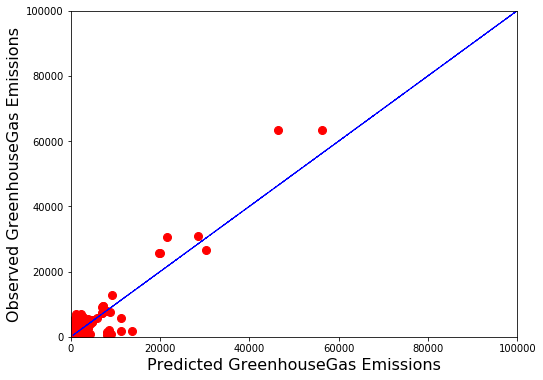

In [95]:
pl.figure(figsize = (8,6))
pl.plot(pred,oil_bmark['Total_GHG'],'or', markersize = 8) # Plot the observed value, linestyle = 'or', red dots
pl.plot(pred,pred,'--b', linewidth = 1)                 # Plot the predicted value, blue dashed line
pl.xlim(0,100000)
pl.ylim(0,100000)
# Plot setting
pl.xlabel('Predicted GreenhouseGas Emissions', fontsize = 16)
pl.ylabel('Observed GreenhouseGas Emissions', fontsize = 16)